# ==== 1D CNN 모델링 ====

In [24]:
import pandas as pd
import numpy as np

# 벡터화된 데이터 불러오기
data = pd.read_json("./labeled_data.json")
data.columns = ["label", "trigram"]

In [25]:
# 3 x 50 -> 150 차원으로 flastten해주는 과정
data['trigram'] = data['trigram'].apply(lambda x: (np.array(x).reshape(-1)))

In [26]:
# train/test 데이터 분리
from sklearn.model_selection import train_test_split

y = data.pop('label')
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# keras 데이터 형식에 맞게 변환
X_train = np.array(X_train['trigram'].tolist())
X_test = np.array(X_test['trigram'].tolist())
y_train = y_train.values
y_test = y_test.values

In [28]:
X_train.shape # row개수 x embeedding차원

(9779, 150)

In [29]:
y_train.shape # row개수 x 1

(9779,)

In [30]:
# keras 모델에 넣기 위한 reshape 과정
def reshape(df, dim):
    return df.reshape(df.shape[0], dim, 1)

In [31]:
X_train = reshape(X_train, 150)
X_test = reshape(X_test, 150)
X_train.shape

(9779, 150, 1)

# ==== CNN ====

In [35]:
# f1 score를 알기 위해 정의한 함수 
# 출처: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [54]:
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras import backend as K

K.clear_session() # session 초기화

model = Sequential()
model.add(Dense(150, input_shape=(X_train.shape[1], 1), activation="relu"))
model.add(BatchNormalization()) 
model.add(Conv1D(filters=100, kernel_size=5, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=3, activation='sigmoid'))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 150, 150)          300       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150)          600       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 100)          75100     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 144, 100)          30100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 100)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4800)             

In [55]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.3)

Train on 6845 samples, validate on 2934 samples
Epoch 1/50
6845/6845 [==============================] - 42s 6ms/step - loss: 0.7094 - acc: 0.6936 - f1_m: 0.8004 - val_loss: 0.5816 - val_acc: 0.7035 - val_f1_m: 0.8249
Epoch 2/50
6845/6845 [==============================] - 39s 6ms/step - loss: 0.4939 - acc: 0.7157 - f1_m: 0.8330 - val_loss: 0.4598 - val_acc: 0.7035 - val_f1_m: 0.8249
Epoch 3/50
6845/6845 [==============================] - 38s 6ms/step - loss: 0.4410 - acc: 0.7234 - f1_m: 0.8367 - val_loss: 0.4408 - val_acc: 0.8054 - val_f1_m: 0.8685
Epoch 4/50
6845/6845 [==============================] - 40s 6ms/step - loss: 0.4249 - acc: 0.8183 - f1_m: 0.8788 - val_loss: 0.4292 - val_acc: 0.8030 - val_f1_m: 0.8674
Epoch 5/50
6845/6845 [==============================] - 39s 6ms/step - loss: 0.4133 - acc: 0.8250 - f1_m: 0.8824 - val_loss: 0.4192 - val_acc: 0.8108 - val_f1_m: 0.8719
Epoch 6/50
6845/6845 [==============================] - 39s 6ms/step - loss: 0.4040 - acc: 0.8324 - f1_m: 0

In [64]:
model.evaluate(X_test, y_test)

4191/4191 [==============================] - 7s 2ms/step


[0.3625960384382891, 0.857790503502461, 0.9014614264113441]

In [62]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

4191/4191 [==============================] - 7s 2ms/step


TypeError: must be real number, not list

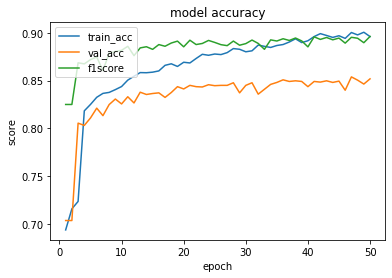

In [61]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.plot(epochs, history.history['val_f1_m'])
plt.title('model accuracy')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc', 'f1score'], loc='upper left')
plt.savefig("./1DCNN reuslt.png")
plt.show()
# train에 대해서 오버피팅 된다. val은 조금 증가하고 왔다갔다한다. epoch은 20정도만해도  충분한 것 같다.

In [58]:
model.save("./cnn_model")